## Overview

The purpose of this notebook is to analyze the dataset of A Thaliana, before applying sequence clustering.

The AAC is calculated und checked for outliers, then a simple ML model is trained to estimate performance

The performance of PSSM and PAAC should correlate with that of AAC. 

This analysis will then be applied to other organisms.

## Imports

In [1]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import labeled_clustermap, get_clusters

## Creating the dataset

In [2]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    verbose = True,
    tax_ids_filter = [3702],
    output_log = "../logs/athaliana_amino_sugar_dataset.log",
)

In [3]:
df.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,2.A,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,0.0,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
Q84WN3,Sugar transport,Membrane;Transmembrane,Transport,SWEET17 At4g15920 dl4000c FCAALL.237,Bidirectional sugar transporter SWEET17 (AtSWE...,NaN,0.0,3702,MAEASFYIGVIGNVISVLVFLSPVETFWKIVKRRSTEEYKSLPYIC...
O04249,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP7 At4g02050 AGAA.1 T10M13.6,Sugar transport protein 7 (Hexose transporter 7),NaN,0.0,3702,MAGGSFGPTGVAKERAEQYQGKVTSYVIIACLVAAIGGSIFGYDIG...
Q56ZZ7,Sugar transport,Membrane;Plastid inner membrane;Transmembrane,Transport,At5g16150 T21H19.70,Plastidic glucose transporter 4 (AtpGlcT),2.A.1.1.102,2.A,3702,MQSSTYAVKGNAAFAFQRRTFSSDRSTTSTGIRFAGYKSLATTGPL...


### Stats

Imbalanced dataset, but enough samples per class. No transporters with two known substrates.

In [4]:
df.keywords_transport.value_counts()

Sugar transport         118
Amino-acid transport     54
Name: keywords_transport, dtype: int64

Two proteins are in MT membrane, are they beta barrel proteins?

In [5]:
df.keywords_location.value_counts()

Membrane;Transmembrane                                        108
Cell membrane;Membrane;Transmembrane                           52
Endoplasmic reticulum;Membrane;Transmembrane                    7
Membrane;Mitochondrion;Transmembrane                            2
Membrane;Plastid inner membrane;Transmembrane                   1
Cell membrane;Endoplasmic reticulum;Membrane;Transmembrane      1
Cell membrane;Membrane;Nucleus;Transmembrane                    1
Name: keywords_location, dtype: int64

No, both are helix bundles

In [6]:
df[df.keywords_location.str.contains("Mito")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9ZU50,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,BAT1 GABP At2g01170 F10A8.5,Amino-acid permease BAT1 (Bidirectional amino ...,NaN,0.0,3702,MGLGGDQSFVPVMDSGQVRLKELGYKQELKRDLSVFSNFAISFSII...
Q8GYB4,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,CAT3 At5g36940 MLF18.60,"Cationic amino acid transporter 3, mitochondrial",NaN,0.0,3702,MGCLRSLVRRKQFDSSNGKAETHHHHQQLAKALTFPHLIAIGVGST...


Nucleus transporter also looks okay, helix bundle and TCDB 2A

In [7]:
df[df.keywords_location.str.contains("Nucleus")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q39134,Amino-acid transport,Cell membrane;Membrane;Nucleus;Transmembrane,Symport;Transport,AAP3 At1g77380 F2P24.9,Amino acid permease 3 (Amino acid transporter ...,2.A.18.2.3,2.A,3702,MVQNHQTVLAVDMPQTGGSKYLDDDGKNKRTGSVWTASAHIITAVI...


Interestingly, many transporters are still annotated with Symport or Antiport, even though only one substrate is known.

In [8]:
df.keywords_transport_related.value_counts()

Transport             114
Symport;Transport      39
Antiport;Transport     19
Name: keywords_transport_related, dtype: int64

The Antiporters all seem to be nucleotide-sugar transporters. They are all annotated as sugar transporters in Uniprot, and nucleotide-sugar transmembrane transporter activity
in GO. The latter is a child of carbohydrate derivative transport. We'll just keep them in the dataset, and see if they influence model fit in a negative way later.

In [9]:
df[df.keywords_transport_related.str.contains("Antiport")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9SRE4,Sugar transport,Membrane;Transmembrane,Antiport;Transport,URGT1 UDP-GALT2 At1g76670 F28O16.4,UDP-rhamnose/UDP-galactose transporter 1 (UDP-...,2.A.7.9.12,2.A,3702,MEKPESEKKSAVSDVGAWAMNVISSVGIIMANKQLMSSSGFGFGFA...
Q6NM25,Sugar transport,Membrane;Transmembrane,Antiport;Transport,UTR5 At3g46180 F12M12.150,UDP-galactose/UDP-glucose transporter 5 (AtUTr5),2.A.7.11.7,2.A,3702,MAEPDSVNEAKEKKKKLWKAVFAISGIMLTLVIYGLLQEKIMRVPY...
Q9LPU2,Sugar transport,Membrane;Transmembrane,Antiport;Transport,URGT2 At1g21070 T22I11.10,UDP-rhamnose/UDP-galactose transporter 2 (UDP-...,2.A.7.9.13,2.A,3702,MEKAENEKKPSAVSDVGAWAMNVTSSVGIIMANKQLMSSSGFGFSF...
O64503,Sugar transport,Endoplasmic reticulum;Membrane;Transmembrane,Antiport;Transport,UTR1 At2g02810 T20F6.5,UDP-galactose/UDP-glucose transporter 1 (At-UD...,2.A.7.11.4,2.A,3702,MEVHGSGFRRILLLALCISGIWSAYIYQGVLQETLSTKRFGPDEKR...
Q9LDX3,Sugar transport,Membrane;Transmembrane,Antiport;Transport,UTR4 At1g12600 F5O11.33 T12C24.13,UDP-galactose/UDP-glucose transporter 4 (AtUTr4),NaN,0.0,3702,MKTNSEEQMIKLFGIPLSDKPRWQQFLICSSGFFFGYLVNGICEEY...
Q29Q28,Sugar transport,Membrane;Transmembrane,Antiport;Transport,UTR2 At4g23010 F7H19.200,UDP-galactose/UDP-glucose transporter 2 (AtUTr2),NaN,0.0,3702,MKEEQTRSLFGISLSDKPTWQQFLICTSGFFFGYLVNGVCEEYVYN...
Q6NMB6,Sugar transport,Membrane;Transmembrane,Antiport;Transport,UTR5B At5g59740 MTH12.11,UDP-galactose/UDP-glucose transporter 5B (AtUT...,NaN,0.0,3702,MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...
Q9M9S6,Sugar transport,Endoplasmic reticulum;Membrane;Transmembrane,Antiport;Transport,UTR3 MSS4 At1g14360 F14L17.13,UDP-galactose/UDP-glucose transporter 3 (AtUTr3),NaN,0.0,3702,MESHGSGLRRVLLLSFCVAGIWAAYIYQGILQETLSTKKFGEDGKR...
Q84L08,Sugar transport,Membrane;Transmembrane,Antiport;Transport,GFT1 GONST4 At5g19980 F28I16.130,GDP-fucose transporter 1 (GDP-mannose transpor...,NaN,0.0,3702,MSSSRFDSNKQLTTSSLVIGYALCSSLLAVINKLAITYFNYPGLLT...


The Symporters all have Protons as their second substrate, that seems to be part of their transport mechanism. 

In [10]:
df[df.keywords_transport_related.str.contains("Symport")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,2.A,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,0.0,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
O04249,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP7 At4g02050 AGAA.1 T10M13.6,Sugar transport protein 7 (Hexose transporter 7),NaN,0.0,3702,MAGGSFGPTGVAKERAEQYQGKVTSYVIIACLVAAIGGSIFGYDIG...
Q9FMX3,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP11 At5g23270 MKD15.13,Sugar transport protein 11 (Hexose transporter...,2.A.1.1.61,2.A,3702,MAGGAFIDESGHGGDYEGRVTAFVMITCIVAAMGGLLFGYDIGISG...
Q8L7R8,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP3 At5g61520 K11J9_40,Sugar transport protein 3 (Hexose transporter 3),NaN,0.0,3702,MVAEEARKEAMAKSVSGGKITYFVVASCVMAAMGGVIFGYDIGVSG...
Q9LT15,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP10 At3g19940 MPN9.19,Sugar transport protein 10 (Hexose transporter...,2.A.1.1.124,2.A,3702,MAGGAFVSEGGGGGRSYEGGVTAFVIMTCIVAAMGGLLFGYDLGIS...
Q39232,Sugar transport,Membrane;Transmembrane,Symport;Transport,SUC1 At1g71880 F17M19.3,Sucrose transport protein SUC1 (Sucrose permea...,2.A.2.4.1,2.A,3702,MGAYETEKPTKDAAALETQSPEDFDQPSPLRKIISVASIAAGVQFG...
O80605,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC3 SUT2 At2g02860 T17M13.3,Sucrose transport protein SUC3 (Sucrose permea...,2.A.2.4.3,2.A,3702,MSDSVSISVPYRNLRKEIELETVTKHRQNESGSSSFSESASPSNHS...
Q93Y91,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP5 At1g34580 F12K21.8,Sugar transport protein 5 (Hexose transporter 5),NaN,0.0,3702,MAGGGLALDVSSAGNIDAKITAAVVMSCIVAASCGLIFGYDIGISG...


#### TCDB

There is one protein classified as a channel, and most proteins have unknown TCDB class. The TCDB class of the unknown proteins will show later, when we will cluster the proteins according to their AAC. Different structure, such as beta barrel or single-pass, usually least to vastly different AAC, so we will find them. 

In [11]:
df.tcdb_class.value_counts()

0.0    114
2.A     57
1.A      1
Name: tcdb_class, dtype: int64

This is the channel. It seems to belong to the GDU family

In [12]:
df[df.tcdb_class.str.startswith("1")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,1.A,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...


There are seven GDU proteins in the dataset. According to Uniprot, they are all single-pass membrane proteins. According to literature, they do not form a transport complex.

In [13]:
df[df.gene_names.str.contains("GDU")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,1.A,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...
Q9SW07,Amino-acid transport,Membrane;Transmembrane,Transport,GDU2 At4g25760 F14M19.40,Protein GLUTAMINE DUMPER 2,NaN,0.0,3702,MQTMEGRQYNYQDSINASSSMVVPHSPWHSPVPYLFGGLAAMLALI...
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,0.0,3702,MEGRQYYPPRENVEGNRTTMGGGPHSPWHSPVPYLFGGLAAMLGLI...
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,0.0,3702,MRPLSIKPTSLDVARHATSVESFGNHRPPISPWHSPVPYLFGGLAA...
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,0.0,3702,MRQFPSIRGNINEKMMTTMVESQTRSPWRTPVPYLFGGLAAMLGLI...
Q3EAV6,Amino-acid transport,Membrane;Transmembrane,Transport,GDU6 At3g30725 T4A2.7,Protein GLUTAMINE DUMPER 6,NaN,0.0,3702,MRPTPKVEIWKSPVPYLFGGLFLLVLLIALALLSLVCTHQKPSSSS...
Q3E8L0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU7 At5g38770 MKD10.70,Protein GLUTAMINE DUMPER 7,NaN,0.0,3702,MSLHRDSMVPVNSRLENMDSPILSKICAWGVMLGLFALSLFAMAYA...


## Feature generation

In [14]:
labels = df.keywords_transport.rename("label").copy()
df_aac = calculate_aac(sequences=df.sequence)
df_paac = calculate_paac(sequences=df.sequence)

The 20 features can be arranged into two clusters. The right one corresponds to hydrophobic residues found in helices, the typical substrate-specificity amino acids are occur more rarely, and can be seen on the left. 

The samples are not clearly separatable into substrates through the ward clustering. Could point to a more complex model, that need many or most of the feature dimensions to separate the classes.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f54140f9c10>)

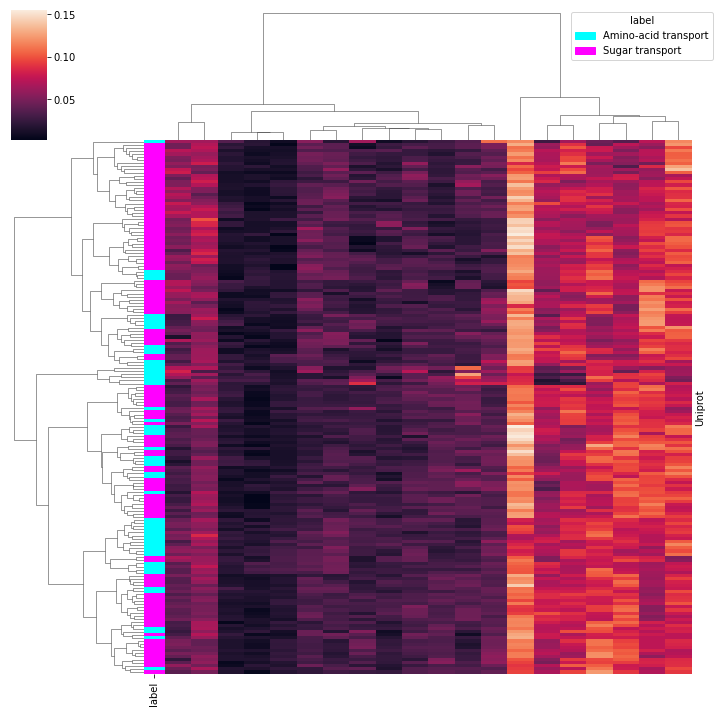

In [16]:
labeled_clustermap(df_aac, labels, legend_bbox=(1.05, 1.25), legend_loc="upper right")

Here, we can see a small set of proteins with a vastly different AAC.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f5d5102b610>)

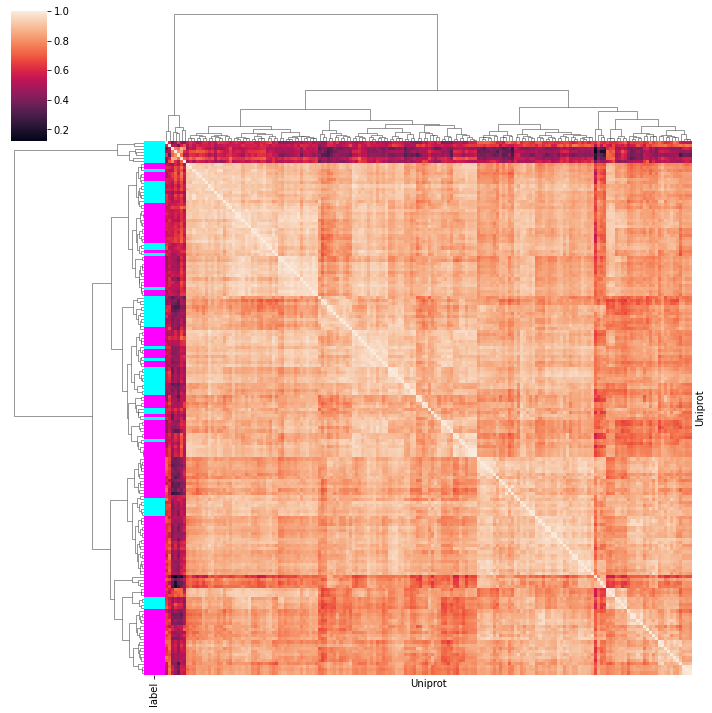

In [ ]:
labeled_clustermap(df_aac.T.corr(), labels)

As it turns out, these are the GDU proteins again.

In [ ]:
clusters = get_clusters(df_aac, n_clusters=3)
df.loc[clusters[2]]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,1.A,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...
Q9SW07,Amino-acid transport,Membrane;Transmembrane,Transport,GDU2 At4g25760 F14M19.40,Protein GLUTAMINE DUMPER 2,NaN,0.0,3702,MQTMEGRQYNYQDSINASSSMVVPHSPWHSPVPYLFGGLAAMLALI...
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,0.0,3702,MEGRQYYPPRENVEGNRTTMGGGPHSPWHSPVPYLFGGLAAMLGLI...
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,0.0,3702,MRPLSIKPTSLDVARHATSVESFGNHRPPISPWHSPVPYLFGGLAA...
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,0.0,3702,MRQFPSIRGNINEKMMTTMVESQTRSPWRTPVPYLFGGLAAMLGLI...
Q3E8L0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU7 At5g38770 MKD10.70,Protein GLUTAMINE DUMPER 7,NaN,0.0,3702,MSLHRDSMVPVNSRLENMDSPILSKICAWGVMLGLFALSLFAMAYA...


labele

In [ ]:
labeled_clustermap(df_aac.loc[clusters[2]])

TypeError: labeled_clustermap() missing 1 required positional argument: 'annotation'

In [ ]:
df_aac.loc[clusters[2]].T.corr().round(3)

Uniprot,O81775,Q9SW07,Q9FHH5,Q8S8A0,Q3E965,Q3E8L0
Uniprot,,,,,,
O81775,1.000,0.754,0.719,0.871,0.792,0.511
Q9SW07,0.754,1.000,0.798,0.847,0.616,0.508
Q9FHH5,0.719,0.798,1.000,0.737,0.508,0.346
Q8S8A0,0.871,0.847,0.737,1.000,0.715,0.584
Q3E965,0.792,0.616,0.508,0.715,1.000,0.680
Q3E8L0,0.511,0.508,0.346,0.584,0.680,1.000
